In [6]:
!pip install kaggle

In [7]:
! kaggle datasets download shubhamgoel27/dermnet

Dataset URL: https://www.kaggle.com/datasets/shubhamgoel27/dermnet
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
dermnet.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
import zipfile

In [9]:
with zipfile.ZipFile("dermnet.zip","r") as f:
    f.extractall("")

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [11]:
BATCH_SIZE = 64
IMAGE_SIZE = 128
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "test",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE  
)

Found 15557 files belonging to 23 classes.
Found 4002 files belonging to 23 classes.


In [12]:
class_names = train_dataset.class_names
class_names


['Acne and Rosacea Photos',
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
 'Atopic Dermatitis Photos',
 'Bullous Disease Photos',
 'Cellulitis Impetigo and other Bacterial Infections',
 'Eczema Photos',
 'Exanthems and Drug Eruptions',
 'Hair Loss Photos Alopecia and other Hair Diseases',
 'Herpes HPV and other STDs Photos',
 'Light Diseases and Disorders of Pigmentation',
 'Lupus and other Connective Tissue diseases',
 'Melanoma Skin Cancer Nevi and Moles',
 'Nail Fungus and other Nail Disease',
 'Poison Ivy Photos and other Contact Dermatitis',
 'Psoriasis pictures Lichen Planus and related diseases',
 'Scabies Lyme Disease and other Infestations and Bites',
 'Seborrheic Keratoses and other Benign Tumors',
 'Systemic Disease',
 'Tinea Ringworm Candidiasis and other Fungal Infections',
 'Urticaria Hives',
 'Vascular Tumors',
 'Vasculitis Photos',
 'Warts Molluscum and other Viral Infections']

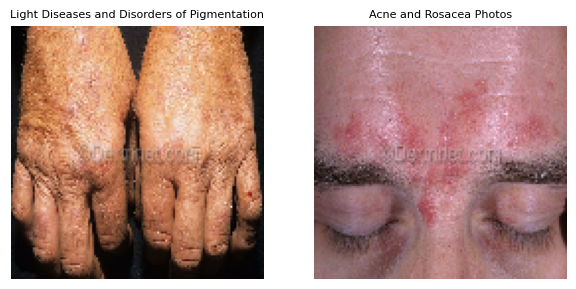

In [13]:
plt.figure(figsize = (15,15))
for image_batch, label_batch in train_dataset.take(1):
  for i in range(2):
     ax = plt.subplot(3,4,i+1)
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]],fontsize = 8)
     plt.axis("off")

In [14]:
def get_dataset_partitions_tf(ds, train_split = 0.8,val_split = 0.2,shuffle = True,shuffle_size = 10000):
  assert(train_split+val_split) == 1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)
  train_size = int(train_split*ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  return train_ds, val_ds

In [15]:
train_ds, val_ds = get_dataset_partitions_tf(train_dataset)

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])


In [18]:
model = models.Sequential([
                           resize_and_rescale,
                           layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3) ),
                           layers.MaxPooling2D((2,2)),
                           layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
                           layers.MaxPooling2D((2,2)), 
                           layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
                           layers.MaxPooling2D((2,2)),    
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),
                           layers.Conv2D(128, (3, 3), activation='relu'),
                           layers.MaxPooling2D((2, 2)),    
                           layers.Flatten(),
                           layers.Dense(128, activation='relu'),
                           layers.Dense(23, activation='softmax')
])
model.build(input_shape = (BATCH_SIZE,128,128,3))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 126, 126, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (64, 63, 63, 64)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (64, 61, 61, 128)         73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 30, 30, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (64, 28, 28, 128)        

In [20]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False,reduction='sum_over_batch_size'),
    metrics=['accuracy']
)

In [21]:
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
) 


Epoch 1/30
195/195 [==============================] - 50s 132ms/step - loss: 2.9745 - accuracy: 0.0970 - val_loss: 2.9327 - val_accuracy: 0.1348
Epoch 2/30
195/195 [==============================] - 18s 89ms/step - loss: 2.8763 - accuracy: 0.1471 - val_loss: 2.7881 - val_accuracy: 0.1774
Epoch 3/30
195/195 [==============================] - 15s 78ms/step - loss: 2.8025 - accuracy: 0.1691 - val_loss: 2.7653 - val_accuracy: 0.1912
Epoch 4/30
195/195 [==============================] - 15s 77ms/step - loss: 2.7293 - accuracy: 0.1910 - val_loss: 2.6978 - val_accuracy: 0.2005
Epoch 5/30
195/195 [==============================] - 15s 78ms/step - loss: 2.6452 - accuracy: 0.2136 - val_loss: 2.6598 - val_accuracy: 0.2171
Epoch 6/30
195/195 [==============================] - 15s 77ms/step - loss: 2.5721 - accuracy: 0.2315 - val_loss: 2.5066 - val_accuracy: 0.2542
Epoch 7/30
195/195 [==============================] - 15s 77ms/step - loss: 2.4965 - accuracy: 0.2517 - val_loss: 2.4383 - val_accuracy

In [51]:
import pickle
filename= 'skin_disease_classification.pkl'

In [52]:
pickle.dump(model,open(filename,'wb'))

INFO:tensorflow:Assets written to: ram://b792d357-efbc-46ea-98f0-97ed05690127/assets


INFO:tensorflow:Assets written to: ram://b792d357-efbc-46ea-98f0-97ed05690127/assets


In [60]:
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save("model.h5", include_optimizer=True)

In [61]:

# Load the entire model
from tensorflow.keras.models import load_model
loaded_model = load_model('model.h5')

# Now you can directly use the model for predictions or further training
predictions = loaded_model.predict(test_dataset)

loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

63/63 [==============================] - 2s 26ms/step


In [62]:
loaded_model.predict(test_dataset)

63/63 [==============================] - 2s 25ms/step


array([[5.1155077e-08, 1.6664628e-06, 3.5490835e-08, ..., 1.3575477e-07,
        3.8076980e-08, 1.7991876e-09],
       [2.1225477e-09, 1.0372123e-07, 7.3221946e-01, ..., 8.0765221e-12,
        2.4021247e-07, 1.6517144e-04],
       [5.2705978e-10, 1.3982422e-04, 1.5718544e-02, ..., 1.1200386e-03,
        8.1251168e-01, 1.2196896e-02],
       ...,
       [1.4658371e-01, 4.8644879e-04, 2.5255617e-01, ..., 6.5399581e-03,
        1.2322088e-02, 6.2991053e-02],
       [2.2522843e-11, 1.8510402e-14, 3.8634926e-08, ..., 4.1297570e-11,
        3.3267482e-12, 1.8365559e-09],
       [2.0692166e-08, 3.1885845e-03, 3.6081275e-08, ..., 3.5460720e-10,
        2.9640967e-07, 9.4397268e-07]], dtype=float32)

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

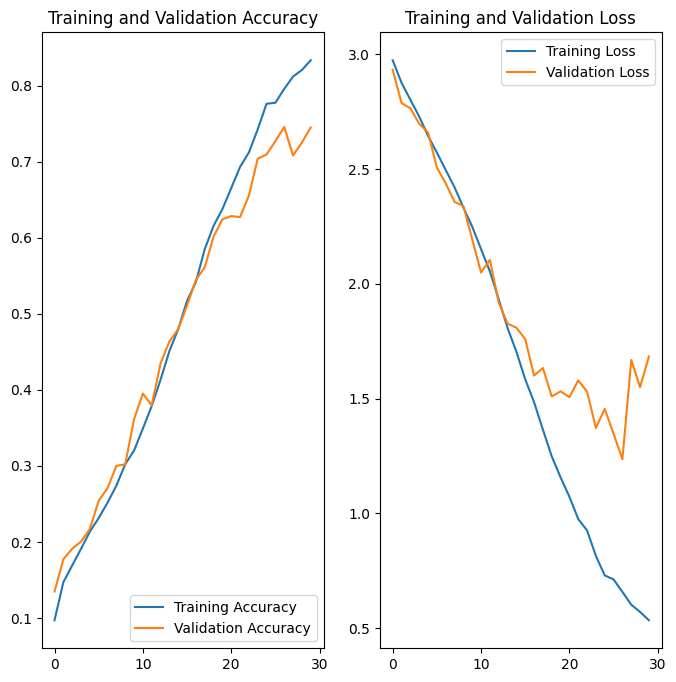

In [64]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [65]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 14ms/step


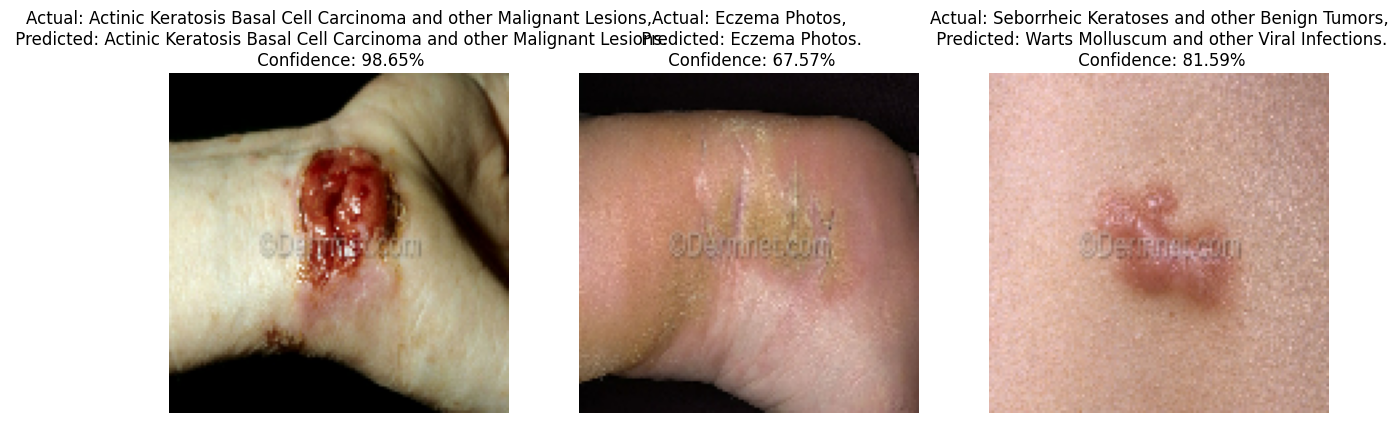

In [66]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")